In [1]:
import numpy as np
import copy
from scipy import stats
import netCDF4 as nc
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
import matplotlib as mpl
import matplotlib.colors as mcolors
from scipy.interpolate import CubicSpline
import time
import pyart
import cmocean
import gsw
import subprocess
from numba import jit
experiment = "MBC_FIX"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color='k',transform=ccrs.PlateCarree(),zorder=42)


In [3]:
def get_deBoyer_mld():
    
    deBoyer_fil = deBoyer_dir + mld_fil
    fid = nc.Dataset(deBoyer_fil)
    lat = fid.variables['lat'][:].squeeze()
    lon = fid.variables['lon'][:].squeeze()
    clon = (lon[:-1] + lon[1:])/2
    clat = (lat[:-1] + lat[1:])/2            
    clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
    clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])
    ref_mld = fid.variables['mld_dr003'][:].squeeze()
    
    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    
    return lat,lon,clon,clat,ref_mld,chuk_mask

In [4]:
def plot_mld(clon,clat,lon,lat,mld,vmin,vmax,cmap,norm,c_inc):
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    C = ax.pcolormesh(clon, clat, mld,cmap=cmap, norm=norm,transform=ccrs.PlateCarree())
    
    levels = np.arange(vmin,vmax+c_inc/2,c_inc)
    CS = ax.contour(lon,lat,mld,levels, colors='k', transform=ccrs.PlateCarree())
    CS.monochrome = True
    plt.draw()
    #print(levels)    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',facecolor='blanchedalmond')
    ax.add_feature(land_50m,zorder=50)
    ax.coastlines('50m',zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)

    # ADDING GRID LINES AND GRID LABELS 
    gl = ax.gridlines(draw_labels=annotate_plots)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    if annotate_plots:
        gl.xlabel_style = {'size': 20}
        gl.ylabel_style = {'size': 20}
        gl.bottom_labels = True
        gl.top_labels = False

        if ncol>0:
            gl.left_labels = False
        
        if ncol<2:
            gl.right_labels = False
            
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    if nrow == len(comp_prods)-1:
        pos = ax.get_position()
        cbar_x = pos.x0
        
        pos_ref = plt.gcf().axes[3].get_position()
        cbar_h = .1*pos_ref.height
        cbar_y = pos_ref.y0 -.25*pos_ref.height
        
        if ncol == 1:
            cax = fig.add_axes([pos_ref.x0, cbar_y, 2*pos.width, cbar_h])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.set_xticks(levels[::2])
            cax.plot([levels]*2, [0, 1], 'k')
            if annotate_plots:
                cbar.ax.tick_params(labelsize=16)
                cax.set_xlabel('Mixed Layer Depth (meters)',fontsize=20)
            else:
                cax.set_xticklabels([])
                
        elif ncol == 3:
            cax = fig.add_axes([pos.x0, cbar_y, pos.width, cbar_h])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.set_xticks(levels[::2])
            cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
            cax.plot([levels[levels<0]]*2, [0, 1], '--k')
            if annotate_plots:
                cbar.ax.tick_params(labelsize=16)
                cax.set_xlabel('Difference (meters)',fontsize=20)
            else:
                cax.set_xticklabels([])
                
    if annotate_plots:
        if ncol == 3:
            stats_text = 'Bias: ' + f'{mean_bias:.2f}' + '\nRMSE: ' + f'{rmse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
            ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)
   
        # Titles
        if ncol == 0:
            title_text = 'NEP10k'
        elif ncol == 1:
            if nrow == 0:
                title_text = 'de Boyer Montégut'
            else:
                title_text = 'GLORYS12'
        else:
            if nrow == 0:
                title_text = 'NEP10k - de Boyer Montégut'
            else:
                title_text = 'NEP10k - GLORYS12'
        
        ax.set_title(title_text, fontsize=28)
        ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
                transform=ccrs.PlateCarree(),zorder=55)          
    
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon), 
                   np.min(nep_clat), 70], crs=ccrs.PlateCarree())  
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
  

In [5]:
def create_regrid_obj(src_clon,src_clat,src_lsm,dst_clon,dst_clat):
    # Make 2D coordinates for remapping
    if len(src_clon.shape)<2:
        src_clon,src_clat = np.meshgrid(src_clon,src_clat)
        
    if len(dst_clon.shape)<2:
        dst_clon,dst_clat = np.meshgrid(dst_clon,dst_clat)
    
    sourcegrid = ESMF.Grid(np.array(src_lsm.shape), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    grid_mask[...] = src_lsm.astype(np.int32) 

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    source_lon[...] = src_clon
    source_lat[...] = src_clat

    sourcefield = ESMF.Field(sourcegrid, name = 'src_field')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
        
    destgrid = ESMF.Grid(np.array(dst_clon[1:,1:].shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_clon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_clat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_clon[...] = dst_clon
    dest_clat[...] = dst_clat

    destfield = ESMF.Field(destgrid, name = 'dest_field')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)

    return sourcefield, destfield, regrid

In [6]:
def calc_stats(nep_val_stats, comp_val_stats, area_val):
    # CALCULATE STATISTICS
    nan_idx = ~np.isnan(nep_val_stats)*~np.isnan(comp_val_stats)
    
    # Mean Bias
    mean_bias = np.nanmean((nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    mean_bias = np.nansum(((nep_val_stats*area_val)[nan_idx]-(comp_val_stats*area_val)[nan_idx])/np.nansum(area_val[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', mean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((nep_val_stats-comp_val_stats)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    rmse = np.sqrt(np.sum((((nep_val_stats-comp_val_stats)**2)*area_val)[nan_idx]/np.sum(area_val[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', rmse)
        
    # Median absolute error
    medae = np.nanmedian(np.abs(nep_val_stats-comp_val_stats)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    corr = stats.pearsonr(nep_val_stats[nan_idx].ravel(), comp_val_stats[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)
    
    return mean_bias, rmse, medae, corr

In [7]:
def get_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (product_dict[src_model]['dir'] + product_dict[src_model]['ncfil'])
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset(ncfil,decode_times=False)
        
    return ds

In [8]:
def get_coords(src_model,ds):
 
    if src_model == 'dBM':
        lon = ds.lon.values
        lat = ds.lat.values
        
    elif src_model == 'GLORYS12':
   
        lon = ds.longitude.values
        lat = ds.latitude.values
                    
    # REGULARLY SPACED LAT/LON, can extrapolate outer corner bounds
    clon = (lon[:-1] + lon[1:])/2
    clat = (lat[:-1] + lat[1:])/2            
    clon = np.insert(np.insert(clon,0,2*clon[0]-clon[1]),-1,2*clon[-1]-clon[-2])
    clat = np.insert(np.insert(clat,0,2*clat[0]-clat[1]),-1,2*clat[-1]-clat[-2])

    lons,lats = np.meshgrid(lon,lat)
    chuk_mask = lats>66
    return lat,lon,clat,clon,chuk_mask

In [9]:
@jit(nopython=True)
def calc_mld_clim():
    
    #glorys_dir = product_dict['GLORYS12']['dir']
    glorys_dir= '/work/role.medgrp/NEP/plotting/Figure_4/'
    ds_glorys_mask =  xr.open_dataset((glorys_dir + 'glorys_nep_mask.nc'),decode_times=False)
    bathym = ds_glorys_mask.deptho.values
    
    glorys_archive_dir = '/archive/e1n/datasets/GLORYS/monthly_means/'
    
    first_calc=True
    for year in range(1993,2019+1):
        print(year)
        for month in time_idx:

            g_ncfil = glorys_archive_dir + 'GLORYS_REANALYSIS_NEP_' + str(year) + '-' + str(month+1).zfill(2) + '.tmp.nc'
            subprocess.run(["dmget",f"{g_ncfil}"])
            g_ds = xr.open_dataset(g_ncfil,decode_times=False)
            
            # get temperature and salt values
            g_temp = g_ds.thetao.values
            g_salt = g_ds.so.values
            
            # calculate potential density for that month and repackage as xarray dataset
            pot_density = gsw.density.sigma0(g_salt, g_temp)
            potdens_ds = xr.DataArray(pot_density, 
                          coords=g_ds.coords, 
                          dims=['time','depth','latitude','longitude'])
            
            potdens_5m = potdens_ds.interp(depth=5.0)
            
            if first_calc:
                dep_idx = np.argmax(potdens_ds.depth.values>dBM_dep) # starting below 5m depth in search for higher density
            arg_max_vals = np.argmax((pot_density[:,dep_idx:,:,:] >= (potdens_5m.values[:,np.newaxis,:,:]+0.03)),axis=1)+dep_idx
            depth_sum = np.sum((pot_density[:,dep_idx:,:,:] >= (potdens_5m.values[:,np.newaxis,:,:]+0.03)),axis=1)

            dens_top = np.squeeze(np.take_along_axis(pot_density, (arg_max_vals[:,np.newaxis,:,:]-1), axis=1))
            dens_bot = np.squeeze(np.take_along_axis(pot_density, (arg_max_vals[:,np.newaxis,:,:]), axis=1))

            depth = potdens_ds.depth.values
            z_top = (depth[arg_max_vals-1]).squeeze()
            z_bot = (depth[arg_max_vals]).squeeze()

            delta_dens = dens_bot-dens_top
            delta_z = depth[arg_max_vals] - depth[arg_max_vals-1]

            # calculating depth below upper layer given the slope, delta_dens/delta_z_l, between layers above and below
            # rho@5m +0.03 kg/m3
            mld = z_top + (((potdens_5m.values+0.03) - dens_top)/(delta_dens))*delta_z

            # anywhere there were no depth layers that met the +0.03 criteria, set mld to bottom depth because 
            # water column is effectively homogeonous with rho@5m
            mld[depth_sum==0] =  np.tile(bathym[np.newaxis,:,:],(mld.shape[0],1,1))[depth_sum==0]
    
            if first_calc:
                mld_stor = mld
                lat,lon,clat,clon,chuk_mask = get_coords(comp_prod,g_ds)
                
                first_calc = False
                
            else:
                mld_stor = np.append(mld_stor,mld,axis=0)
    
    # generate climatologies
    mld_clim = np.mean(mld_stor.reshape((-1,len(time_idx),mld_stor.shape[1],mld_stor.shape[2])),axis=0)
    
    return lat,lon,clat,clon,chuk_mask,mld_clim  

In [10]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

In [11]:
deBoyer_dir = './'

e1n_dir = './'

season_dict = {'mean':{'vmin':10,'vmax':90,  'cbar_n':17, 'inc':10, 'dif_range':32, 'dif_cbar_n':25, 'dif_inc':8}}

plot_labels = ['a','b','c','d','e','f']


In [12]:
product_dict = {'NEP':{'dir':f'/work/Utheri.Wagura/NEP/plotting/Figure_4/{experiment}/', 
                       'ncfil':'nep_MLD_003_1993-2019_clim.nc','mld_var':'MLD_003'},
                'dBM':{'dir':'/work/role.medgrp/NEP/plotting/Figure_4/',
                        'ncfil':'mld_dr003_ref5m_v2024.nc','mld_var':'mld_dr003'},
                'GLORYS12':{'dir':'/work/role.medgrp/NEP/plotting/Figure_4/',
                          'ncfil':['']}}

/work/Utheri.Wagura/NEP/plotting/Figure_4/MBC_FIX/nep_MLD_003_1993-2019_clim.nc
/work/role.medgrp/NEP/plotting/Figure_4/mld_dr003_ref5m_v2024.nc
MEAN BIAS: -4.204931885700039
AREA-WEIGHTED MEAN BIAS: -4.591528568255012
RMSE: 12.128738138741893
AREA-WEIGHTED RMSE: 12.38443113921416
MEDIAN ABSOLUTE ERROR: 6.442085881215611
CORRELATION: PearsonRResult(statistic=0.7259368680242572, pvalue=0.0)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'get_coords':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../vftmp/Utheri.Wagura/pid333942/ipykernel_428772/1972195807.py", line 57:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

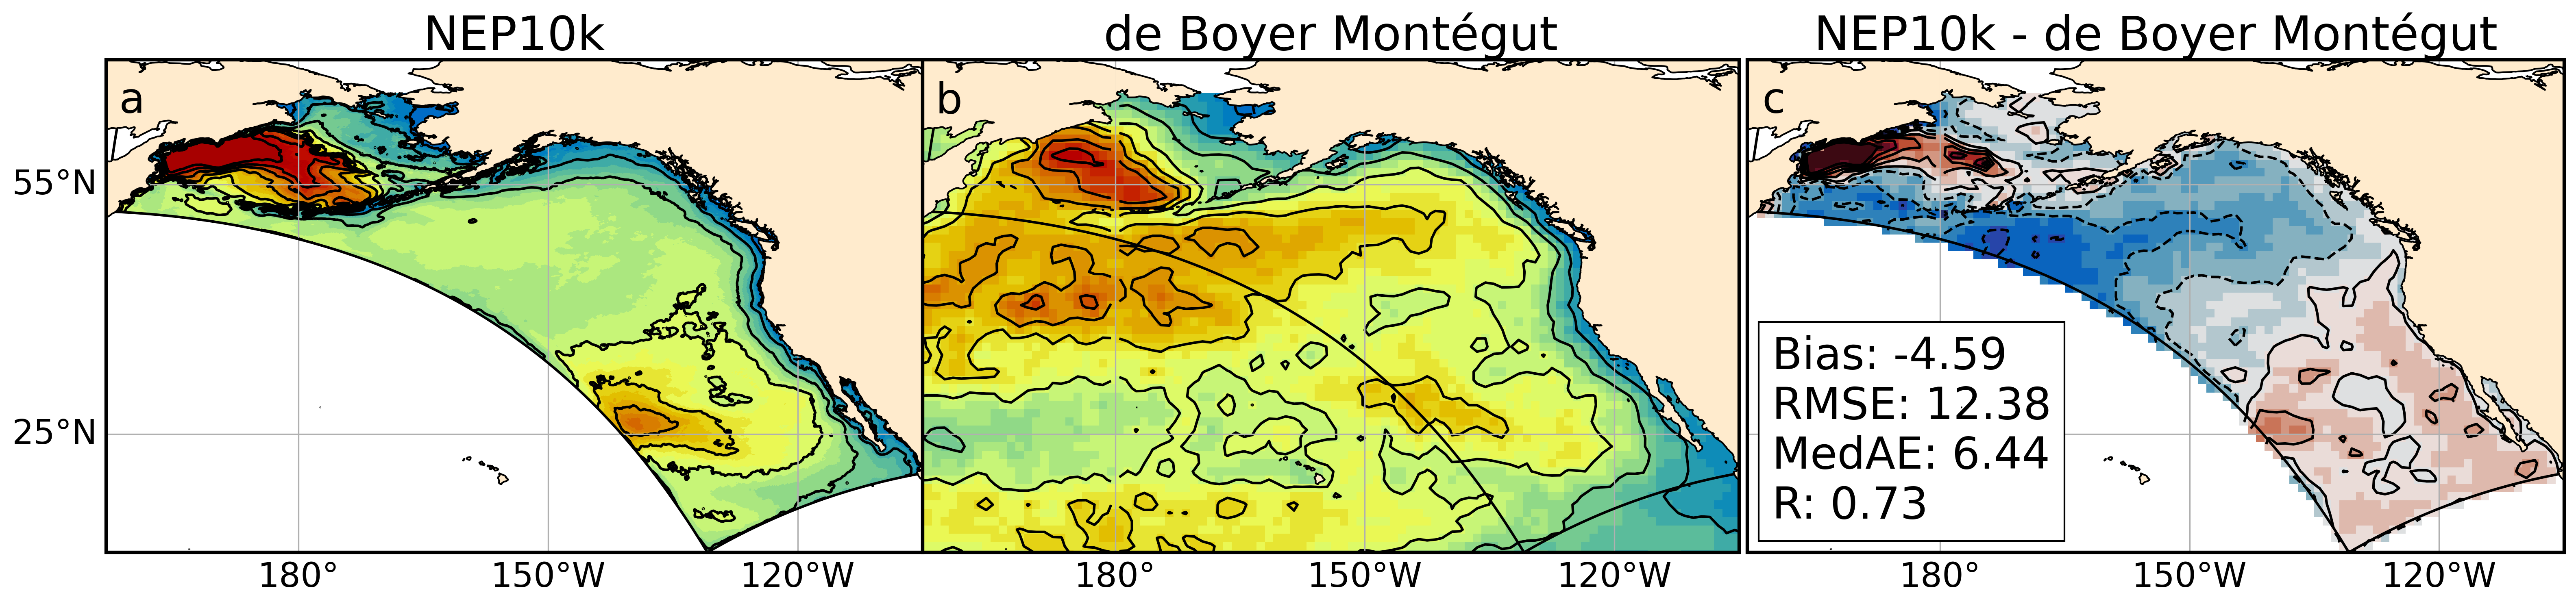

In [13]:
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)   
print_stats = True
const_offset = 500
plot_GLORYS = True
annotate_plots = True

if plot_GLORYS:
    comp_prods =  ['dBM', 'GLORYS12']
    fig_nrows=2
    fig_ht = 14 
else:
    comp_prods = ['dBM']
    fig_nrows=1
    fig_ht = 7
    
dBM_dep = 5.0
ds_nep = get_ds('NEP')

for tim_frame, time_idx in zip(['mean'],[np.arange(12)]):

    nrow = 0
    nlab = 0
    
    fig = plt.figure(figsize=(26,fig_ht),dpi=300)
    widths = [10,10,.1,10]
    spec = fig.add_gridspec(ncols=4, nrows=fig_nrows,wspace=0,hspace=0.,width_ratios=widths) 
    
    for comp_prod in comp_prods:
        ncol = 0
        nep_mld = ds_nep[product_dict['NEP']['mld_var']].values[time_idx,:]
        #print(nep_mld.shape)
        if comp_prod == 'dBM':
            ds_ref = get_ds(comp_prod)
            lat,lon,clat,clon,chuk_mask = get_coords(comp_prod,ds_ref)
            ref_mld = ds_ref[product_dict[comp_prod]['mld_var']].values[time_idx,:]
            
            # create regrid object: NEP -> dBM
            sourcefield, destfield, regrid = create_regrid_obj(nep_clon,nep_clat,lsm,clon,clat)
            
            nep_val_out = np.zeros((len(time_idx),len(lat),len(lon)))
            for nt in range(len(time_idx)):
                sourcefield.data[...] = nep_mld[nt,:].squeeze() + const_offset 
                destfield = regrid(sourcefield, destfield)
                tmp_val = copy.deepcopy(destfield.data)
                tmp_val[tmp_val==0] = np.nan
                nep_val_out[nt,:] = tmp_val - const_offset
               
            sourcefield.data[...] = lsm + const_offset
            destfield = regrid(sourcefield, destfield)
            tmp_val = copy.deepcopy(destfield.data)
            tmp_val[tmp_val==0] = np.nan
            lsm_out = tmp_val - const_offset
            lsm_out[lsm_out>.5]=1
            lsm_out[lsm_out<.5]=0
            
            comp_diff_val = copy.deepcopy(ref_mld)
            comp_diff_val = np.mean(comp_diff_val,axis=0)
            # remove chukchi sea
            comp_diff_val[chuk_mask] = np.nan
            # remove values outside NEP domain
            comp_diff_val[lsm_out==0] = np.nan
                
            nep_diff_val = copy.deepcopy(nep_val_out)
            nep_diff_val = np.mean(nep_diff_val,axis=0)
            # remove chukchi sea
            nep_diff_val[chuk_mask] = np.nan
            # remove values outside NEP domain
            nep_diff_val[lsm_out==0] = np.nan 
                
            # Get area for weighted statistics 
            sourcefield.data[...] = nep_area + const_offset
            destfield = regrid(sourcefield, destfield)
            tmp_val = copy.deepcopy(destfield.data)
            tmp_val[tmp_val==0] = np.nan
            area_out = tmp_val - const_offset
            
            dif_clon = clon; dif_clat = clat
            dif_lon = lon; dif_lat = lat
        
        else:
            
            lat,lon,clat,clon,chuk_mask,ref_mld = calc_mld_clim()
            ref_lsm = ~np.isnan(ref_mld[0,:].squeeze())
            
            # create regrid object: GLORYS -> NEP
            sourcefield, destfield, regrid = create_regrid_obj(clon,clat,ref_lsm,nep_clon,nep_clat)
                
            # regrid GLORYS to NEP
            nt1,nj,ni = nep_mld.shape
            comp_val_out = np.zeros((nt1,nj,ni))
            for nt in range(nt1):
                sourcefield.data[...] = ref_mld[nt,:].squeeze() + const_offset
                destfield = regrid(sourcefield, destfield)
                tmp_val = copy.deepcopy(destfield.data)
                tmp_val[tmp_val==0] = np.nan
                comp_val_out[nt,:] = tmp_val - const_offset
        
            comp_diff_val = copy.deepcopy(comp_val_out)
            comp_diff_val = np.mean(comp_diff_val,axis=0)
            comp_diff_val[nep_lat>66] = np.nan
            comp_diff_val[lsm==0] = np.nan
                
            nep_diff_val = copy.deepcopy(nep_mld)
            nep_diff_val = np.mean(nep_diff_val,axis=0)
            nep_diff_val[nep_lat>66] = np.nan
            nep_diff_val[lsm==0] = np.nan
        
            area_out = copy.deepcopy(nep_area)
            dif_clon = nep_clon; dif_clat = nep_clat
            dif_lon = nep_lon; dif_lat = nep_lat
                    
        ref_mld = np.nanmean(ref_mld,axis=0)
        nep_mld = np.nanmean(nep_mld,axis=0)
        
        ref_mld[chuk_mask] = np.nan
        nep_mld[nep_lat>66] = np.nan   

        # Colorbars
        cmap2 = cmocean.cm.balance
        bounds = np.linspace(-season_dict[tim_frame]['dif_range'],
                         season_dict[tim_frame]['dif_range'],
                         season_dict[tim_frame]['cbar_n'])
        norm2 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')

        cmap1 = 'pyart_HomeyerRainbow'
        bounds = np.linspace(season_dict[tim_frame]['vmin'],
                         season_dict[tim_frame]['vmax'],
                         season_dict[tim_frame]['dif_cbar_n'])
        norm1 = mcolors.BoundaryNorm(bounds, 256, extend='both')

        plot_mld(nep_clon,nep_clat,nep_lon,nep_lat,nep_mld,
             season_dict[tim_frame]['vmin'],season_dict[tim_frame]['vmax'],
             cmap1,norm1,season_dict[tim_frame]['inc'])

        ncol+=1
        nlab+=1

        plot_mld(clon,clat,lon,lat,ref_mld,
             season_dict[tim_frame]['vmin'],season_dict[tim_frame]['vmax'],
             cmap1,norm1,season_dict[tim_frame]['inc'])

        ncol+=2
        nlab+=1
    
        # CALCULATE STATISTICS
        mean_bias, rmse, medae, corr = calc_stats(nep_diff_val,comp_diff_val,area_out)

        plot_mld(dif_clon,dif_clat,dif_lon,dif_lat,nep_diff_val-comp_diff_val,
                 -season_dict[tim_frame]['dif_range'],season_dict[tim_frame]['dif_range'],
                 cmap2,norm2,season_dict[tim_frame]['dif_inc'])
        nlab+=1
        
        fig_str = f'/work/Utheri.Wagura/NEP/plotting/Figure_4/{experiment}/Figure4_NEP_dBM_2024_GLORYS_mld_comp_1993-2019_mean'
    
        nrow+=1
    plt.savefig(fig_str)

    